In [1]:

import osmnx as ox
import networkx as nx
import geopandas as gpd
import pandas as pd
from shapely.wkt import loads
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
import folium
from folium.plugins import MiniMap
from folium.plugins import MeasureControl
from folium.plugins import MarkerCluster


In [2]:
output_path = "./figures/"
plt.rcParams["font.family"] = "Inter"
plt.rcParams.update({
    'xtick.color': '#737373',       # X-axis tick color
    'ytick.color': '#737373',       # Y-axis tick color
    'axes.labelcolor': '#737373',   # Axis labels color
    'axes.edgecolor': '#737373',    # Spines (axes edge) color
})

In [3]:
# load data
sites = gpd.read_parquet('../data/processed/moz.parquet')  
graph = ox.load_graphml(filepath="../data/processed/moz.graphml")
health_facilities = gpd.read_parquet('../data/processed/moz_healthsites.parquet') 
bbox = gpd.read_file("../data/external/Moz-adm0.gpkg").total_bounds


In [4]:
# country_border = gpd.read_file('../data/external/Moz-adm0.gpkg')
# country_polygon = country_border.geometry.iloc[0]


In [5]:
# graph_all = ox.graph.graph_from_xml('../data/external/mozambique.osm')
# graph_all  = ox.truncate.truncate_graph_polygon(G=graph_all, polygon=country_polygon)
# ox.io.save_graphml(G=graph_all, filepath="../data/processed/moz.graphml")

In [6]:
# get data for area of focus
bbox = gpd.read_file("../data/external/Mandruzi.geojson").total_bounds

graph_focus = ox.truncate.truncate_graph_bbox(graph, bbox=bbox)
health_facilities_focus = gpd.clip(health_facilities, bbox)
sites_focus = sites[sites['1.1.d.1 Site Name'] == 'Mandruzi']
path = ox.routing.route_to_gdf(G=graph, route=sites_focus['route'].item()) # for one site
sites_good = sites[sites['distance_meters'] != 0] # remove sites in health facilities (it was giving an error)

# create a gdf for all routes
routes_gdfs = []
for route in sites_good['route'].head(68):
    route_gdf = ox.routing.route_to_gdf(G=graph, route=route)
    routes_gdfs.append(route_gdf)

merged_routes_gdf = gpd.GeoDataFrame(pd.concat(routes_gdfs, ignore_index=True))


# route for Mandruzi
coords_list = [
    [(y, x) for x, y in geom.coords] if geom.geom_type != 'Point' else [(geom.y, geom.x)]
    for geom in path.geometry
]

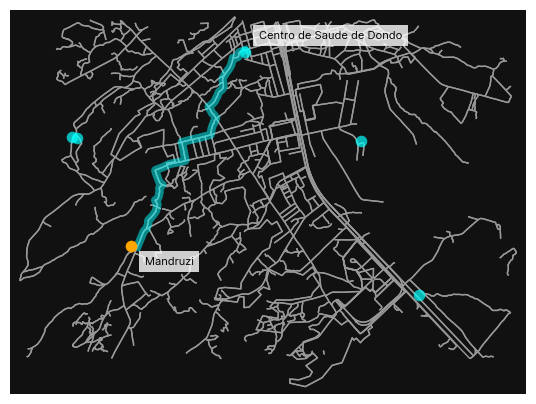

In [7]:

# orig = gdf[gdf['1.1.d.1 Site Name'] == 'Mandruzi']['nearest_node'].iloc[0]
# dest = gdf[gdf['1.1.d.1 Site Name'] == 'Mandruzi']['nearest_health_facility_node'].iloc[0]
# route = ox.shortest_path(graph, orig, dest, weight="length")

# prep the values
orig = sites_focus['nearest_node'].item()
orig_name = sites_focus['1.1.d.1 Site Name'].item()
dest = sites_focus['nearest_health_facility_node'].item()
dest_name = sites_focus['nearest_health_facility_name'].item()
route = sites_focus['route'].item()

# plot static map
fig, ax = ox.plot_graph_route(graph_focus, route, route_color="cyan", route_linewidth=6, node_size=0, orig_dest_size=0, show=False, close=False, figsize=(6.66,6.66))
health_facilities.plot(ax=ax, color='cyan', alpha=0.7, markersize=70, zorder=2, linewidth=0)
sites_focus.plot(ax=ax, color='orange', alpha=1, markersize=70, zorder=3, linewidth=0)

orig_point = Point(graph.nodes[orig]['x'], graph.nodes[orig]['y'])
dest_point = Point(graph.nodes[dest]['x'], graph.nodes[dest]['y'])

o = ax.text(orig_point.x+0.001, orig_point.y-0.002, 'Mandruzi', fontsize=8, color='black', va='center')
o.set_bbox(dict(facecolor='white', alpha=0.8, linewidth=0))
d = ax.text(dest_point.x+0.002, dest_point.y+0.002, 'Centro de Saude de Dondo', fontsize=8, color='black', va='center')
d.set_bbox(dict(facecolor='white', alpha=0.8, linewidth=0))

#ax.set_title("Mandruzi site - nearest health facility", fontsize=14)

fig.savefig(f"{output_path}moz-static-focus.svg", format="svg", bbox_inches='tight', dpi=120, pad_inches = 0.1)
#fig.savefig(f"{output_path}moz-static-focus.png", format="png", bbox_inches='tight', dpi=300, pad_inches = 0)
plt.show()



In [8]:

health= [[point.xy[1][0], point.xy[0][0]] for point in health_facilities.geometry]

map = folium.Map(location=[ -19.630, 34.735], tiles="CartoDB dark_matter", zoom_start=14, max_bounds=False, control_scale=True, zoom_control='topleft') # or dark_matter
# folium.TileLayer("CartoDB dark_matter").add_to(map)
# map_title = "Mandruzi  is approx. 4km (49mins walk) to its nearest health facility"
# title_html = f'<h3 style="position:absolute;z-index:100000;left:10vw;color:#DCDCDC" >{map_title}</h1>'
# map.get_root().html.add_child(folium.Element(title_html))

# map health facilities
i = 0
for coordinates in health:
    map.add_child(
        folium.Marker(
            location=coordinates,
            tooltip="Type:"
            + str(health_facilities.iloc[0]["amenity"])
            + "<br>"
            + "Name: "
            + str(health_facilities.iloc[i]["name"]),
            icon=folium.Icon(icon="hospital", prefix="fa",color="green"),
        )
    )
    i = i + 1

marker = folium.Marker(
    location=[sites_focus.geometry.y.item(), sites_focus.geometry.x.item()],
    popup=folium.Popup("Site: " + str(sites_focus['1.1.d.1 Site Name'].item()), show=True),
    icon = folium.Icon(icon="building", prefix="fa",color="orange")
)
marker.add_to(map)

line = folium.PolyLine(tooltip="Distance: 4,049 metres", locations=coords_list, color='#00FFFF', weight=5, opacity=0.8)
line.add_to(map)

MiniMap(tile_layer="Cartodb positron", zoom_level_offset=-8).add_to(map)
map.add_child(MeasureControl())

map.save(f"{output_path}moz-dynamic-mandruzi.html")
map


In [9]:
# interactive map showing all sites, facilities and routes

health_list = [[point.xy[1][0], point.xy[0][0]] for point in health_facilities.geometry]
sites_list = [[point.xy[1][0], point.xy[0][0]] for point in sites.geometry]
routes_list = [[line.xy[1][0], line.xy[0][0]] for line in merged_routes_gdf.geometry]

map = folium.Map(location=[ -19.630, 34.735], tiles="CartoDB dark_matter", zoom_start=10, max_bounds=False, control_scale=True, zoom_control='topleft') # or dark_matter
marker_cluster1 = MarkerCluster().add_to(map)
marker_cluster2 = MarkerCluster().add_to(map)



# map health facilities
i = 0
for coordinates in health_list:
    marker_cluster1.add_child(
        folium.Marker(
            location=coordinates,
            tooltip="Type:"
            + str(health_facilities.iloc[0]["amenity"])
            + "<br>"
            + "Name: "
            + str(health_facilities.iloc[i]["name"]),
            icon=folium.Icon(icon="hospital", prefix="fa",color="green"),
        )
    )
    i = i + 1

# map sites
i = 0
for coordinates in sites_list:
    marker_cluster2.add_child(
        folium.Marker(
            location=coordinates,
            tooltip=
            "Name: "
            + str(sites.iloc[i]["1.1.d.1 Site Name"]),
            icon=folium.Icon(icon="building", prefix="fa",color="blue"),
        )
    )
    i = i + 1

# map routes
for _, row in merged_routes_gdf.iterrows():
    # Extract the coordinates from the LineString geometry
    coords = [(point[1], point[0]) for point in row.geometry.coords]
    # Add the PolyLine to the map
    folium.PolyLine(locations=coords, color='#00FFFF').add_to(map)

MiniMap(tile_layer="Cartodb positron", zoom_level_offset=-6).add_to(map)
map.add_child(MeasureControl())
marker_cluster = MarkerCluster().add_to(map)


map.save(f"{output_path}moz-dynamic-all.html")
map


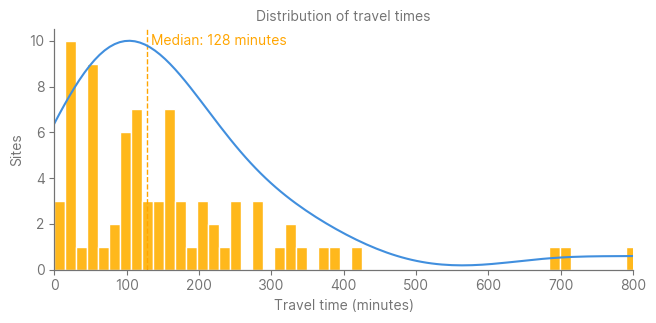

In [ ]:
import seaborn as sns
median_value = sites['walking_time_minutes'].median().item()

fig, ax = plt.subplots(figsize=(6.66,3.33))
ax.hist(sites['walking_time_minutes'], bins=int(sites['walking_time_minutes'].max().item()/15), edgecolor='white', color='#FFB81C')
ax.set_xlabel('Travel time (minutes)')
ax.set_ylabel('Sites')
ax.spines[['top','right']].set_visible(False)
ax.set_title('Distribution of travel times - computational approach', fontsize=10, color="#737373")
ax.axvline(median_value, color='orange', linestyle='dashed', linewidth=1)
ax.text(median_value + 5, 10, f'Median: {median_value:.0f} minutes', color='orange', va='center')
#ax.axvline(sites['walking_time_minutes'].mean().item(), color='green', linestyle='dashed', linewidth=1)

ax2 = ax.twinx()
sns.kdeplot(data=sites['walking_time_minutes'], ax=ax2, color='#418FDE')
ax2.set_yticklabels([])  # Remove the labels on the right
ax2.spines[['top','right']].set_visible(False)
ax2.tick_params(axis='both', which='both', length=0)  # Remove all ticks
ax2.set_yticks([])  # Remove y-axis ticks
ax2.set_ylabel('')

ax.set_xlim(0, 800)

fig.tight_layout()
fig.savefig(f"{output_path}moz-static-hist-computed.svg", format="svg", bbox_inches='tight', dpi=120, pad_inches = 0.1)
plt.show()


In [11]:
sites['walking_time_minutes'].max().item()/15


60.758890199004675

In [12]:
sites['walking_time_minutes'].describe()

count     80.000000
mean     179.725400
std      189.634538
min        0.000000
25%       59.105911
50%      127.980402
75%      213.781399
max      911.383353
Name: walking_time_minutes, dtype: float64

In [13]:
sites['How long does it take to reach the nearest health facility from the site?'].unique().tolist()

['More than 60 minutes',
 '31 - 60 minutes',
 '16 - 30 minutes',
 'Less than 15 minutes']

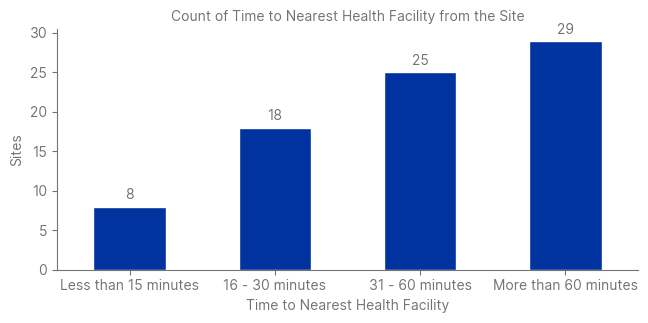

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'sites' is your GeoDataFrame
# Get the counts of unique values in the specified column
value_counts = sites['How long does it take to reach the nearest health facility from the site?'].value_counts()

# Define the desired order
desired_order = ['Less than 15 minutes', '16 - 30 minutes', '31 - 60 minutes', 'More than 60 minutes']

# Reindex the value_counts to match the desired order
value_counts = value_counts.reindex(desired_order)

# Create a bar chart using the object-oriented approach
fig, ax = plt.subplots(figsize=(6.66, 3.33))
bars = value_counts.plot(kind='bar', ax=ax, color='#0033A0', edgecolor='white')
ax.set_xlabel('Distribution of travel times - key informant approach')
ax.set_ylabel('Sites')
ax.set_title('Count of Time to Nearest Health Facility from the Site', fontsize=10, color="#737373")

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Label the bars with the count values using bar_label
ax.bar_label(bars.containers[0], padding=3, color="#737373")

# Set x tick labels rotation to 0
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

fig.tight_layout()
fig.savefig(f"{output_path}moz-static-hist-ki.svg", format="svg", bbox_inches='tight', dpi=120, pad_inches = 0.1)

plt.show()

In [15]:

# Assuming 'sites' is your GeoDataFrame and it has a 'walking_time_minutes' column
# Define the bins and labels
bins = [0, 15, 30, 60, float('inf')]
labels = ['Less than 15 minutes', '16 - 30 minutes', '31 - 60 minutes', 'More than 60 minutes']

# Create the 'converted' column using pd.cut
sites['converted'] = pd.cut(sites['walking_time_minutes'], bins=bins, labels=labels, right=False)


In [16]:
sites['match'] = sites['How long does it take to reach the nearest health facility from the site?'] == sites['converted']


In [17]:
sites['match'].value_counts()

match
False    46
True     34
Name: count, dtype: int64

In [18]:
sites['match'].value_counts(normalize=True)

match
False    0.575
True     0.425
Name: proportion, dtype: float64

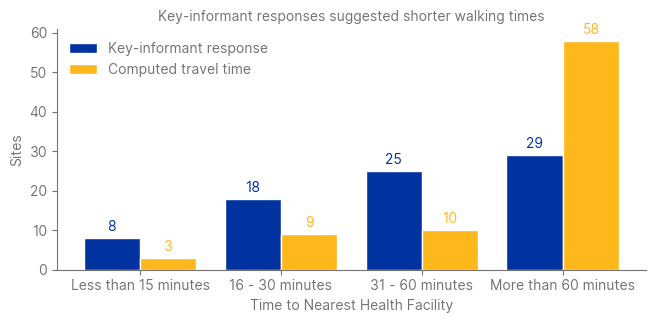

In [19]:
# Get the value counts for both columns
value_counts_original = sites['How long does it take to reach the nearest health facility from the site?'].value_counts().reindex(labels)
value_counts_converted = sites['converted'].value_counts().reindex(labels)

# Create a bar chart using the object-oriented approach
fig, ax = plt.subplots(figsize=(6.66, 3.33))

# Plot the value counts for both columns
width = 0.4  # Width of the bars
x = range(len(labels))  # X-axis positions for the bars

bars_original = ax.bar([pos - width/2 for pos in x], value_counts_original.values, width=width, label='Key-informant response', color='#0033A0', edgecolor='white')
bars_converted = ax.bar([pos + width/2 for pos in x], value_counts_converted.values, width=width, label='Computed travel time', color='#FFB81C', edgecolor='white')

# Set labels and title
ax.set_xlabel('Time to Nearest Health Facility')
ax.set_ylabel('Sites')
ax.set_title('Key-informant responses suggested shorter walking times', fontsize=10, color="#737373")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=0)
ax.legend(frameon=False, labelcolor="#737373")  # Remove the legend outline box

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Label the bars with the count values using bar_label
ax.bar_label(bars_original, padding=3, color="#0033A0")
ax.bar_label(bars_converted, padding=3, color="#FFB81C")

fig.tight_layout()
fig.savefig(f"{output_path}moz-static-bar-comparison.svg", format="svg", bbox_inches='tight', dpi=120, pad_inches = 0.1)

plt.show()

In [20]:
m = sites.explore("match", cmap="bwr_r", tiles = "CartoDB dark_matter", marker_kwds={"radius":5}, style_kwds={"stroke":False,"fillOpacity":.9})
m.save(f"{output_path}moz-dynamic-match.html")
m
